In [2]:
import numpy as np
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (Dense,Conv2D,Conv2DTranspose,Reshape,
                                     Dropout,Activation,Lambda,Input,Concatenate,
                                     BatchNormalization,MaxPooling2D,Lambda)
import json
import cv2
from tensorflow.keras.utils import plot_model

In [3]:
def plot_imgs(imgs,gts,label):
    num = 4
    if(len(gts.shape)<4):
      gt_idx = gts
      gts = np.zeros_like(gts)
      gts = 255*np.eye(6)[gt_idx]

    fig,axs = plt.subplots(num,7,figsize=(10,5))
    fig.text(0.5, 0.92, label, ha='center', va='center', fontsize=16)

    for i in range(num):
        axs[i][0].imshow(imgs[i])
        for j in range(6):
          axs[i][j+1].imshow(gts[i][:,:,j],cmap='gray')


In [4]:
def convblock(in_tensor,filters,kernel,batch_norm=False,stride=1):

    #first_layer
    #batch_norm = False
    lyr = Conv2D(filters,kernel_size=kernel,
                 strides=stride,padding='same',
                 kernel_initializer='he_normal')(in_tensor)
    #if batch_norm:
    #    lyr = BatchNormalization()(lyr)
    act = Activation('relu')(lyr)

    #Seconde layer

    lyr2 = Conv2D(filters,kernel_size=kernel,
                  strides=stride,padding='same',
                  kernel_initializer='he_normal')(act)
    if batch_norm:
        lyr2 = BatchNormalization()(lyr2)
    act2 = Activation('relu')(lyr2)


    return act2

In [5]:
def parse(example_point):
    feature_key = {
        'image' : tf.io.FixedLenFeature([],tf.string),
        'globuls_mask' : tf.io.FixedLenFeature([],tf.string),
        'milia_like_cyst_mask' : tf.io.FixedLenFeature([],tf.string),
        'negative_network_mask' : tf.io.FixedLenFeature([],tf.string),
        'pigment_network_mask' : tf.io.FixedLenFeature([],tf.string),
        'streaks_mask' : tf.io.FixedLenFeature([],tf.string)
    }
    in_shape = (128,128)
    example = tf.io.parse_single_example(example_point,feature_key)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, (512,512,3))
    image = tf.image.resize(image, size=in_shape)
    image = image/255.0

    m1 = tf.io.decode_jpeg(example['globuls_mask'], channels=1)
    m1 = tf.reshape(m1, (512,512,1))
    m1 = tf.image.resize(m1,size=in_shape)
    m1 = m1/255.0

    m2 = tf.io.decode_jpeg(example['milia_like_cyst_mask'], channels=1)
    m2 = tf.reshape(m2, (512,512,1))
    m2 = tf.image.resize(m2,size=in_shape)
    m2 = m2/255.0

    m3 = tf.io.decode_jpeg(example['negative_network_mask'], channels=1)
    m3 = tf.reshape(m3, (512,512,1))
    m3 = tf.image.resize(m3,size=in_shape)
    m3 = m3/255.0

    m4 = tf.io.decode_jpeg(example['pigment_network_mask'], channels=1)
    m4 = tf.reshape(m4, (512,512,1))
    m4 = tf.image.resize(m4,size=in_shape)
    m4 = m4/255.0

    m5 = tf.io.decode_jpeg(example['streaks_mask'], channels=1)
    m5 = tf.reshape(m5, (512,512,1))
    m5 = tf.image.resize(m5,size=in_shape)
    m5 = m5/255.0

    m6 = tf.ones_like(m1,dtype=tf.float32)
    m6 = tf.math.abs(m6-(m1+m2+m3+m4+m5))


    masks = tf.concat([m1,m2,m3,m4,m5,m6],axis=-1)
    masks = tf.argmax(masks,axis=-1)

    return image,masks

In [6]:
train_file = '/content/drive/MyDrive/reshaped/train.tfrecord'
dataset = tf.data.TFRecordDataset(train_file)
dataset = dataset.map(parse)
batch_size= 8
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = iter(dataset)

In [9]:
def lr_schedule(epoch):
  initial_lr = 0.001
  decay_factor = 0.99
  decay_epochs = 1
  lrate = initial_lr * (decay_factor ** (epoch // decay_epochs))
  return lrate

In [11]:
def create_unet():
    filters = [64,128,256,512,1024]
    dropout = 0.0
    in_lyr = Input(shape=(128,128,3))

    #Down Sampling

    c1 = convblock(in_lyr,kernel=3,filters=filters[0],batch_norm=True)
    p1 = MaxPooling2D((2,2))(c1)
    d1 = Dropout(dropout)(p1)

    c2 = convblock(d1,kernel=3,filters=filters[1],batch_norm=True)
    p2 = MaxPooling2D((2,2))(c2)
    d2 = Dropout(dropout)(p2)

    c3 = convblock(d2,kernel=3,filters=filters[2],batch_norm=True)
    p3 = MaxPooling2D((2,2))(c3)
    d3 = Dropout(dropout)(p3)

    c4 = convblock(d3,kernel=3,filters=filters[3],batch_norm=True)
    p4 = MaxPooling2D((2,2))(c4)
    d4 = Dropout(dropout)(p4)

    #Middle Part

    c_1 = convblock(d4,kernel=3,filters=filters[4],batch_norm=True)

    #Upsampling

    u5 = Conv2DTranspose(filters[3],kernel_size=3,strides=2,padding="same")(c_1)
    cat1 = Concatenate(axis=-1)([c4,u5])
    d5 = Dropout(dropout)(cat1)
    c5 = convblock(d5,kernel=3,filters=filters[2],batch_norm=True)

    u6 = Conv2DTranspose(filters[2],kernel_size=3,strides=2,padding="same")(c5)
    cat2 = Concatenate(axis=-1)([c3,u6])
    d6 = Dropout(dropout)(cat2)
    c6 = convblock(d6,kernel=3,filters=filters[1],batch_norm=True)

    u7 = Conv2DTranspose(filters[1],kernel_size=3,strides=2,padding="same")(c6)
    cat3 = Concatenate(axis=-1)([c2,u7])
    d7 = Dropout(dropout)(cat3)
    c7 = convblock(d7,kernel=3,filters=filters[0],batch_norm=True)

    u8 = Conv2DTranspose(filters[0],kernel_size=3,strides=2,padding="same")(c7)
    cat4 = Concatenate(axis=-1)([c1,u8])
    d8 = Dropout(dropout)(cat4)
    c8 = convblock(d8,kernel=3,filters=filters[0],batch_norm=True)

    out_lyr = Conv2D(6,kernel_size=3,activation='softmax',padding='same')(c8)

    model = tf.keras.Model(inputs=in_lyr,outputs=out_lyr)

    return model


In [12]:
file_path = '/content/drive/MyDrive/reshaped/checkpoint'

save_model = tf.keras.callbacks.ModelCheckpoint(file_path,
                                                monitor='loss',
                                                save_best_only=True,
                                                save_weights_only=False)

#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                  patience=3,
                                                  restore_best_weights=True)

In [13]:
tf.random.set_seed(42)
model = create_unet()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam())


In [15]:
history = model.fit(dataset,epochs=100,callbacks=[save_model,early_stopping])

Epoch 1/100
325/325 [==============================] - 88s 174ms/step - loss: 0.2099
Epoch 2/100
325/325 [==============================] - 55s 157ms/step - loss: 0.1646
Epoch 3/100
325/325 [==============================] - 53s 153ms/step - loss: 0.1599
Epoch 4/100
325/325 [==============================] - 55s 158ms/step - loss: 0.1552
Epoch 5/100
325/325 [==============================] - 54s 156ms/step - loss: 0.1515
Epoch 6/100
325/325 [==============================] - 53s 154ms/step - loss: 0.1502
Epoch 7/100
325/325 [==============================] - 57s 158ms/step - loss: 0.1499
Epoch 8/100
325/325 [==============================] - 53s 153ms/step - loss: 0.1459
Epoch 9/100
325/325 [==============================] - 55s 155ms/step - loss: 0.1458
Epoch 10/100
325/325 [==============================] - 56s 158ms/step - loss: 0.1443
Epoch 11/100
325/325 [==============================] - 45s 130ms/step - loss: 0.1448
Epoch 12/100
325/325 [==============================] - 56s 158

In [ ]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore('/content/drive/MyDrive/reshaped/checkpoint')  # Specify the path to your checkpoint file

In [21]:
batch = next(train_dataset)
pred_gts = model.predict(batch[0])

1/1 [==============================] - 0s 23ms/step


In [22]:
batch[1].shape

TensorShape([8, 128, 128])

In [23]:
max_idx = np.argmax(pred_gts, axis=-1)
result = np.zeros_like(pred_gts)
result = 255*np.eye(6)[max_idx]

1/1 [==============================] - 0s 22ms/step


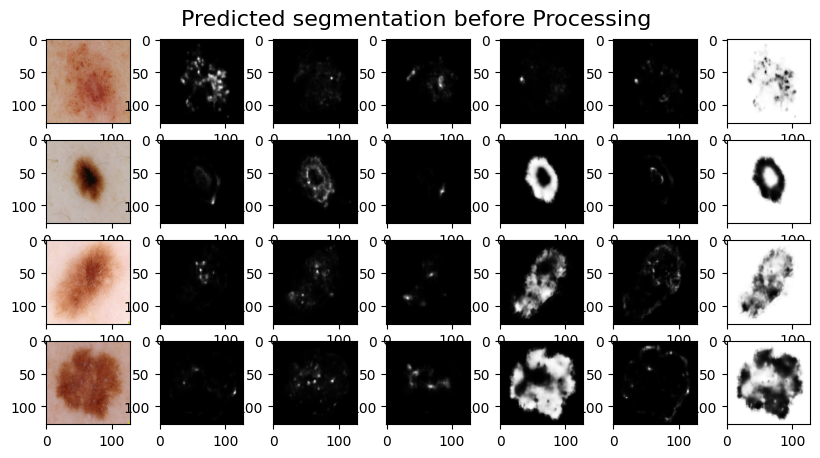

In [24]:
pred_gts = model.predict(batch[0])
plot_imgs(batch[0],pred_gts,'Predicted segmentation before Processing')

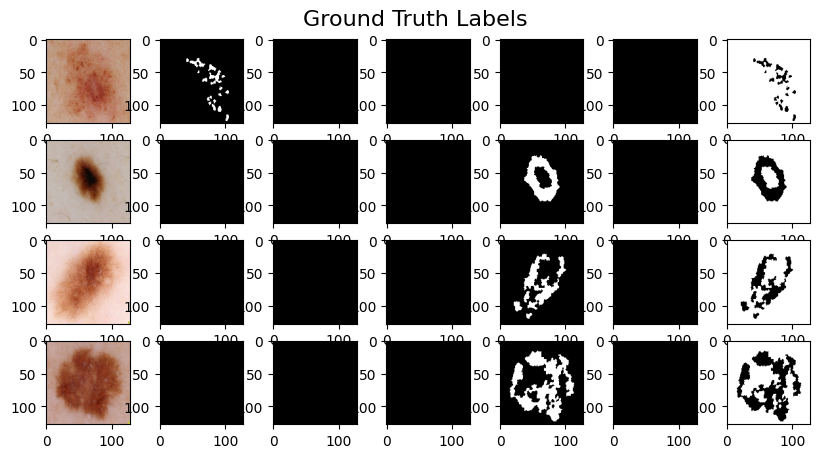

In [25]:
plot_imgs(batch[0],batch[1],'Ground Truth Labels')

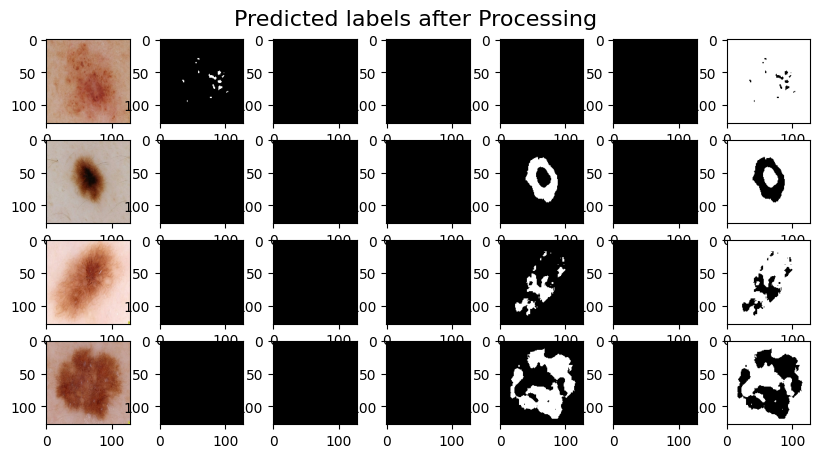

In [26]:
plot_imgs(batch[0],result,'Predicted labels after Processing')

In [27]:
loss = history.history['loss']
#acc = history.history['mean_io_u']

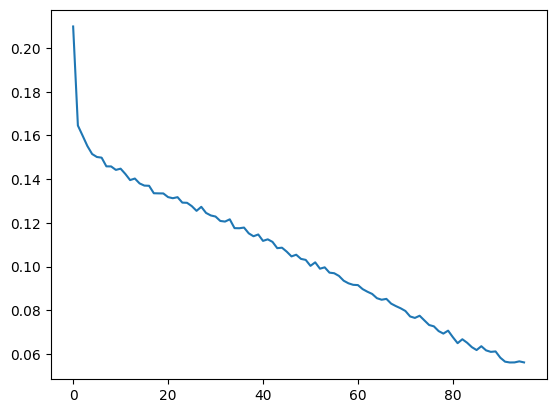

In [28]:
plt.plot(loss)